# Molecule-based analysis on an Idiopathic Pulmonary Fibrosis Lung tissue 

# Introduction

For a real-world sample, the number of detected transcripts is in the scale of millions. For example, in our previous study on pulmonary fibrosis ([Vanan & Lyu, 2024](https://doi.org/10.1038/s41588-025-02080-x)), the total number of transcripts detected per sample ranges from 3 million to 21 million for lung tissue cores of size 3mm-5mm in diameters. The vast amount of total transcripts across all samples in one study makes the processing all samples in one process impractical.   

Since the graph sampling is embedded in the GraphSAGE framework, we can adopt sample tiling and do graph-sampling per tile to address the large-scale multiple sample integration challenge. For the analysis below, we look at one sample fibrotic sample VUILD91LF.
 



# SpatialRNA dataset

To manage the input transcripts and the tiling process in a convenient way, we create the `spatialRNA` class which inherits the `Dataset` class from `pyG`. It is in charge of preprocessing the input transcripts from the entire tissue, and create the data object for downstream analysis.

### Create tiles from input tiusse

![tile_tissues](../figures/tile_tissues.jpg)

In the plot above, we use the middle grid to represent the tissue, the other three grids represent the tiles generated from the tissue.

We set the process mode to "tile" and can choose an axis such as X or Y for generating the tiles. When we tile the tissue, we flag transcripts whose spatial neighbours have not be disrupted as "core". In addition, we add padding for each tile so that every transcript has the chance of being flagged as "core", e.g., the shaded blue area in tiles in the above plot. 

When we make inference per tile, we use the tile graphs as inputs and will only focus on the "core" transcripts. Joining all core transcripts from all tiles will make up the full list of transcripts in the input tissue.

![tile_tissues_graphs](../figures/tile_graph_subgraph.jpg)

Graph object for each tile will be created and stored in ./datadir_root/sample_name/processed/sample_name_data_tile0.pt.
We can further sample a subgraph from each tile for large datasets. 

In [ ]:
import pandas as pd 
import numpy as np 
from torch_geometric.nn import radius_graph
from torch_geometric import seed_everything
import torch 
import os.path as osp
import time  
import torch.nn.functional as F 

import torch_geometric.transforms as T
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import GraphSAGE,GAT
import torch.nn.functional as F
from torch_geometric.data import Data
import numpy as np
from torch_geometric.transforms import RandomNodeSplit
import random 
import sys
import matplotlib.pyplot as plt
import os.path as osp
from pathlib import Path

In [ ]:
#import importlib 
import spatialrna 
SpatialRNA = spatialrna.SpatialRNA


## Gene panel of 343 genes 

In [ ]:
gene_panel = pd.read_csv(
    "../data/spatial_ipf.gene.panels.csv")
gene_panel

We make sure the same gene is encoded with the same integer ID across samples.

In [ ]:
gene_list = np.unique(gene_panel.x)
x = torch.tensor(np.arange(gene_list.shape[0]))
one_hot_encoding = dict(zip(gene_list, F.one_hot(x, num_classes=gene_list.shape[0]).type(torch.float)))
gene_to_int = {key: torch.argmax(value).item() for key, value in one_hot_encoding.items()}
#gene_to_int

In [ ]:
gene_to_int["CD3E"]

# Create tissue tiles and tile graphs

`SpatialRNA` tiles the tissues according to the num_tiles supplied. The process_tile_ids controls which tile(s) to process for in one function call, and one tile at a time is recommended (or necessisary) for large tissues. Once the tiles are all processed, graphs created from tiles are saved to the "processed" directory. 

In [ ]:
!ls -l  ../data/spatialRNA_samples/

In [ ]:
## Creat tiles per sample


In [ ]:
sample_name = "VUHD116A"
dataset_dir = Path("../data/spatialRNA_samples/")
# Create the SpatialRNA object with the specified parameters    
data = SpatialRNA(
    root = dataset_dir / f'{sample_name}/' ,
    sample_name=sample_name,
    one_hot_encoding=gene_to_int,
    num_tiles = 5,
    dim_x = "x_location", # x coordinate column name in the CSV file
    dim_y = "y_location", # y coordinate column name in the CSV file
    tile_by_dim="y_location", # tile by dimension, can be "X" or "Y"
    process_mode="tile", # to create tile graph,
    load_type="tile", # load_type can be "blank", no data will be loaded; "graph", load tile graph; "subgraph", load the sampled subgraph.
    feature_col="feature_name", # feature column name in the CSV file
    force_reload=True,
    process_tile_ids=[x for x in range(5)], ## Recursivly process first and the second tile. Can choose to only process one tile per process, and use slurm batch job to batch process. 
    num_neighbours=[-1,-1], # number of neighbours for each layer, -1 means all neighbours
    radius_r=3.0 # 
)


The code above takes the input transcripts for sample VUHD116A, and created 5 tiles (cutting along y_location). It also loaded the first tile data to `data`. We next can have a look at the loaded tile graph:

In [ ]:
## Print informtion of the first tile graph:
data[0]

We see there are 490022 nodes and 27637158 edges. There is also the trans_id attribute that maps the nodes to each input transcripts in the input csv file (map to integer row ids). `core_mask` is a bool vector specifying whether each node is in the core or the padding area, which is useful for the `inference` function later.

In [ ]:
## Process the second sample "VUILD91LF"

In [ ]:
sample_name = "VUILD91LF"
dataset_dir = Path("../data/spatialRNA_samples/")
# Create the SpatialRNA object with the specified parameters    
SpatialRNA(
    root = dataset_dir / f'{sample_name}/' ,
    sample_name=sample_name,
    one_hot_encoding=gene_to_int,
    num_tiles = 10,
    dim_x = "x_location", # x coordinate column name in the CSV file
    dim_y = "y_location", # y coordinate column name in the CSV file
    tile_by_dim="y_location", # tile by dimension, can be "X" or "Y"
    process_mode="tile", # create tile graph, currently only one tile.
    load_type="blank", # load_type can be "blank", no data will be loaded; "graph", load tile graph; "subgraph", load the sampled subgraph.
    feature_col="feature_name", # feature column name in the CSV file
    force_reload=True,
    process_tile_ids=[x for x in range(10)], ## Recursivly process first till the 10th tile. Can choose to only process one tile per process, and use slurm batch job to batch process. 
    num_neighbours=[-1,-1], # number of neighbours for each layer, -1 means all neighbours
    radius_r=3.0 # 
)


## OnDiskDataLoader via spatialrna_ondisk

We’ve generated the tile graphs for both samples. Now we’ll use an OnDiskDataLoader to load them in batches so we don’t overload the RAM.

In [ ]:
import spatialrna.spatialrna_ondisk as spod
#from spatialrna import SpatialRNA
## we tell the constructor that our pt files are in dirname processed
myod = spod.SpatialRNAOnDiskDataset(root = "../data/spatialRNA_samples/",pt_dir="processed")
myod.len()


In [ ]:
## We can use get, or multi_get to load the pt files by selection
## myod.get(0)
## myod.multi_get([0,1])

In [ ]:
# Uncomment if splitting the graph tiles in myod to Train and Validation.
# Split indices: 80% train, 20% validation
# 
# indices = list(range(len(myod)))
# train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
# train_idx[0:5], val_idx[0:5],len(train_idx),


Construct a train loader with batch size 10. It loads 10 of the 15 tile graphs each time.

In [ ]:
from torch_geometric.loader import DataLoader

# use the 15 tiles for training # can select a sub group too.
train_idx = [x for x in range(15)]
train_dataset = myod.index_select(train_idx)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2)
#val_loader   = DataLoader(val_dataset, batch_size=20, shuffle=False, num_workers=2)


## Construct GNN model, GraphSAGE

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
number_class = gene_panel.shape[0]
model = GraphSAGE(
    number_class,
    hidden_channels=50,
    num_layers=2).to(device)

In [ ]:
## Model training 
## use the train function 
import spatialrna.train_val as train_val

In [ ]:
### Run the training process for 10 epochs
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
from time import time
times = []
for epoch in range(1, 11):
    start = time()
    loss,acc = train_val.train(
                model=model,
                train_loader=train_loader,
                device=device,
                num_classes=number_class,
                optimizer=optimizer,
                num_neighbors=[20,10],
                num_train_edges=100000, # sample this many positive edges in each batch (of 10 tile graphs). Roughly 10_000 per tile.
            verbose=False)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.3f}')
    times.append(time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")


In [ ]:
torch.save(model, '../data/spatialRNA_samples/graphsgae_trained.pth')

# Make inference using the trained model

Using the the trained model, we make inference to get embeddings of transcripts in each tile. 

In [ ]:
model = torch.load('../data/spatialRNA_samples/graphsgae_trained.pth',weight_only=True)
model

In [26]:
train_val.inference(
    model=model, 
    device=device,
    sample_name="VUHD116A",                
    root="../data/spatialRNA_samples/VUHD116A/",
    tile_id=[x for x in range(5)],      
    num_classes=number_class,   
    num_neighbors=[20,10])

/mnt/beegfs/mccarthy/general/backed_up/rlyu/Projects/spatialrna_dev0.2/spatialrna/spatialrna/train_val.py:297: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.loa

In [28]:
train_val.inference(
    model=model, 
    device=device,
    sample_name="VUILD91LF",                
    root="../data/spatialRNA_samples/VUILD91LF/",
    tile_id=[x for x in range(10)],      
    num_classes=number_class,   
    num_neighbors=[20,10])

100%|██████████| 76/76 [00:03<00:00, 20.20it/s]


### Generated embedding using the trained model

In [35]:
ls ../data/spatialRNA_samples/VUILD91LF/embedding/

VUILD91LF_data_tile0input_tx_id.csv  VUILD91LF_data_tile5input_tx_id.csv
VUILD91LF_data_tile0.npy             VUILD91LF_data_tile5.npy
VUILD91LF_data_tile1input_tx_id.csv  VUILD91LF_data_tile6input_tx_id.csv
VUILD91LF_data_tile1.npy             VUILD91LF_data_tile6.npy
VUILD91LF_data_tile2input_tx_id.csv  VUILD91LF_data_tile7input_tx_id.csv
VUILD91LF_data_tile2.npy             VUILD91LF_data_tile7.npy
VUILD91LF_data_tile3input_tx_id.csv  VUILD91LF_data_tile8input_tx_id.csv
VUILD91LF_data_tile3.npy             VUILD91LF_data_tile8.npy
VUILD91LF_data_tile4input_tx_id.csv  VUILD91LF_data_tile9input_tx_id.csv
VUILD91LF_data_tile4.npy             VUILD91LF_data_tile9.npy


Each .npy file stores a numpy array of N by 50 (50 dims of latent embeddings). The paired input_tx_id.csv file helps to make sure each row of embedding matrix matches with the input transcripts in the csv file.


## Run kmeans clustering using the run_kmeans

We will load and join the embedding matrices from tiles of the two samples together and run kmeans clustering on all transcripts.

In [34]:
from spatialrna import run_kmeans

In [36]:
run_kmeans.run_kmeans(root="../data/spatialRNA_samples/",
                      sample_name_list =["VUHD116A","VUILD91LF"],
                      downsample_to=None, # when the number of input transcripts are huge
                      downsample_seed=1024,
                      n_clusters=12,
                      split_file_per_sample=True,
                      verbose=False)

The clustering results for each sample is now saved at:


In [40]:
ls ../data/spatialRNA_samples/VUILD91LF/clusters/

VUILD91LF.12clusters.csv


In [41]:
ls ../data/spatialRNA_samples/VUHD116A/clusters/;

VUHD116A.12clusters.csv


## Match with transcript meta information and do plots

In [44]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080','#e6beff',
 '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
 '#000075', '#808080', '#ffffff', '#000000']
len(colors)

22

In [45]:
from spatialrna import viz

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from spatialrna import viz
# import importlib
# importlib.reload(viz)

<module 'spatialrna.viz' from '/mnt/beegfs/mccarthy/general/backed_up/rlyu/Projects/spatialrna_dev0.2/spatialrna/spatialrna/viz.py'>

In [48]:
tx_meta_with_clusters_vuhd116a = viz.get_tx_plot_df(
    root="../data/spatialRNA_samples/",
    sample_name="VUHD116A",
    n_clusters=12)

In [50]:
tx_meta_with_clusters_vuild91lf = viz.get_tx_plot_df(
    root="../data/spatialRNA_samples/",
    sample_name="VUILD91LF",
    n_clusters=12)

In [52]:
tx_meta_with_clusters_vuild91lf.head(2)

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,gmm12,x_centroid,y_centroid,tx_ids,cluster_labels
0,VUILD91LF_281479271677952,VUILD91LF_aaaabjbi-1,0,KDR,607.80695,583.53973,17.333397,40.0,K16,0.410278,3,612.38168,582.162479,0,5
1,VUILD91LF_281479271677955,VUILD91LF_aaaabjbi-1,0,EPAS1,608.54880,589.26495,15.235544,40.0,K16,1.900856,3,612.38168,582.162479,1,7


In [89]:
customise_cmap = dict(zip([x for x in range(12)],colors))
customise_cmap

{0: '#e6194b',
 1: '#3cb44b',
 2: '#ffe119',
 3: '#4363d8',
 4: '#f58231',
 5: '#911eb4',
 6: '#46f0f0',
 7: '#f032e6',
 8: '#bcf60c',
 9: '#fabebe',
 10: '#008080',
 11: '#e6beff'}

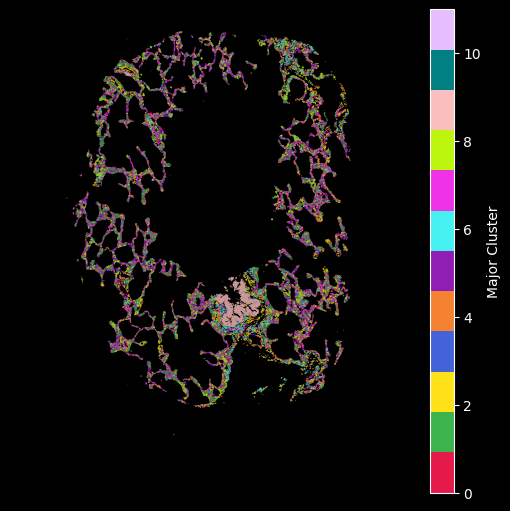

In [90]:
hex_plot,ax = viz.plot_hex_bin(tx_meta = tx_meta_with_clusters_vuhd116a,
                 x="x_location",
                 y="y_location",
                 cluster_labels="cluster_labels",
                 bin_thresh=10,
                 bin_width=5,
                 # figsize=(10, 10),
                 # dpi=150
                 cmap=customise_cmap,
                 background_color="black")
ax.set_axis_off()

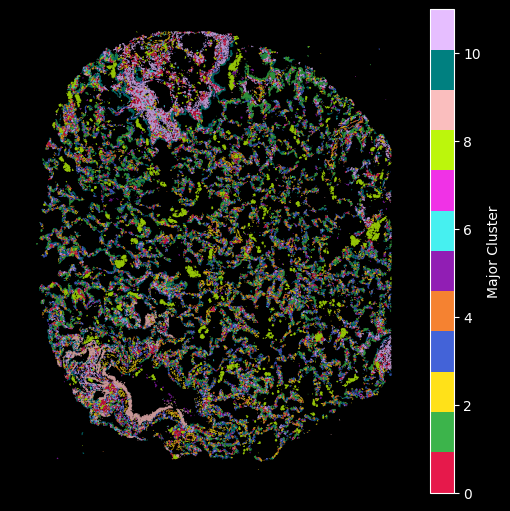

In [91]:
hex_plot,ax = viz.plot_hex_bin(tx_meta = tx_meta_with_clusters_vuild91lf,
                 x="x_location",
                 y="y_location",
                 cluster_labels="cluster_labels",
                 bin_thresh=10,
                 bin_width=5,
                 figsize=(5, 5),
                 cmap=customise_cmap,
                 background_color="black")
ax.set_axis_off()

Using the customised color map dictionary we can also control the visualisation to only show the selected clusteres.

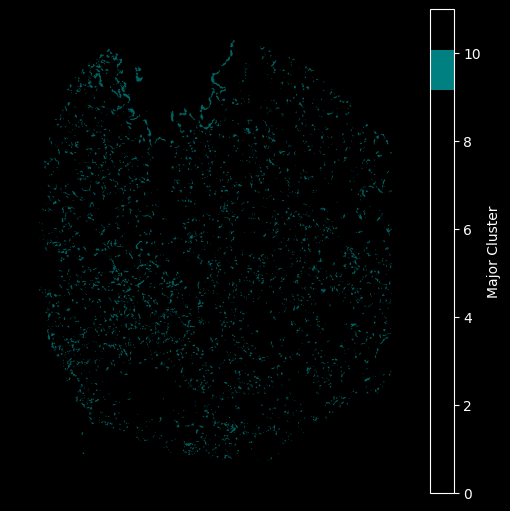

In [99]:
## Only plot the transcripts in cluster 10:
hex_plot,ax = viz.plot_hex_bin(tx_meta = tx_meta_with_clusters_vuild91lf,
                 x="x_location",
                 y="y_location",
                 cluster_labels="cluster_labels",
                 bin_thresh=10,
                 bin_width=5,
                 figsize=(5, 5),
                 cmap={10: '#008080'},
                 background_color="black")
ax.set_axis_off()

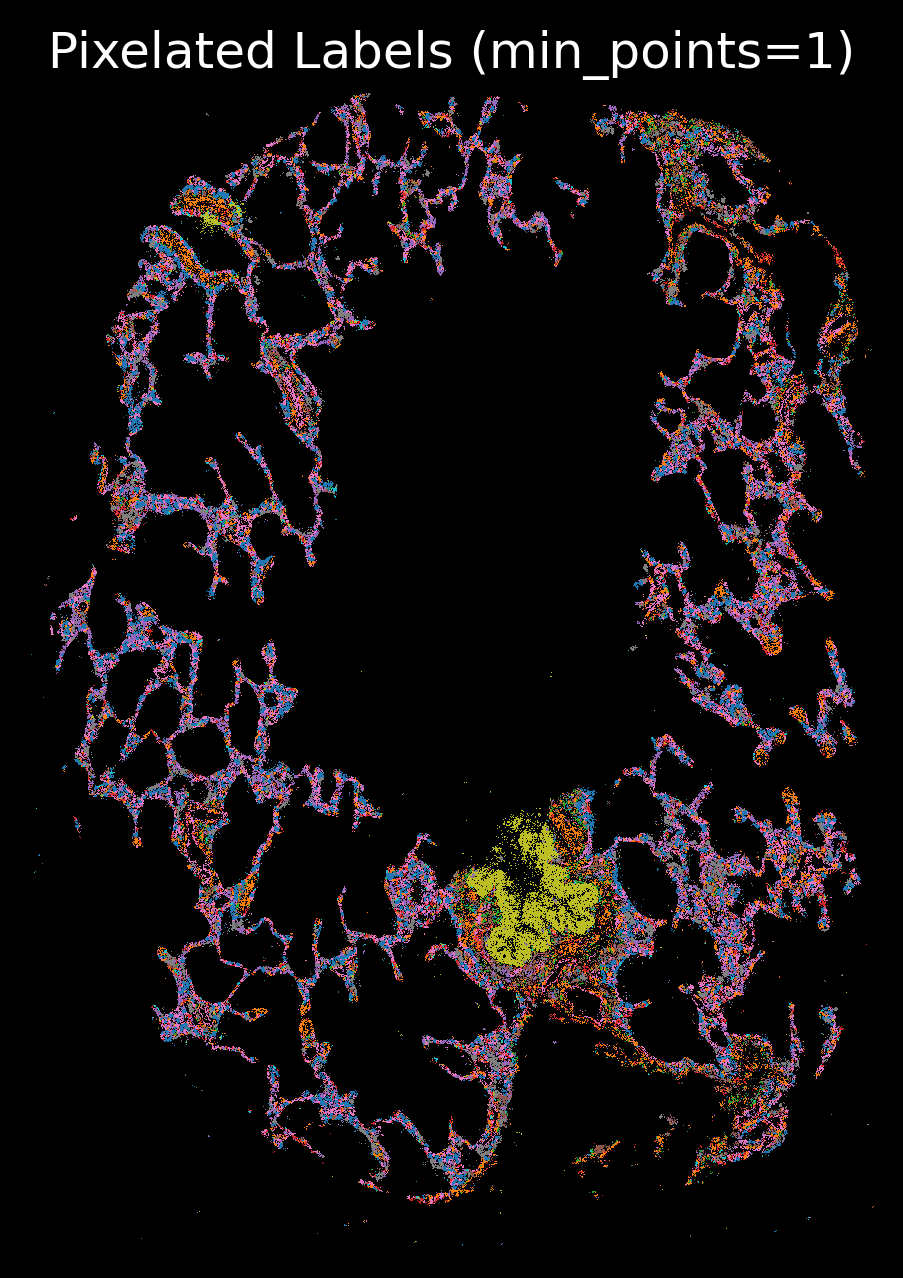

In [96]:
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'black'
plt.style.use('dark_background')
p_fig,ax = viz.plot_pixel(tx_meta = tx_meta_with_clusters_vuhd116a,
                          x="x_location",
                          y="y_location",pixel_size=1,min_points=1,
                          background_color="black",dpi=300,figsize=(5,5))
ax.invert_yaxis()

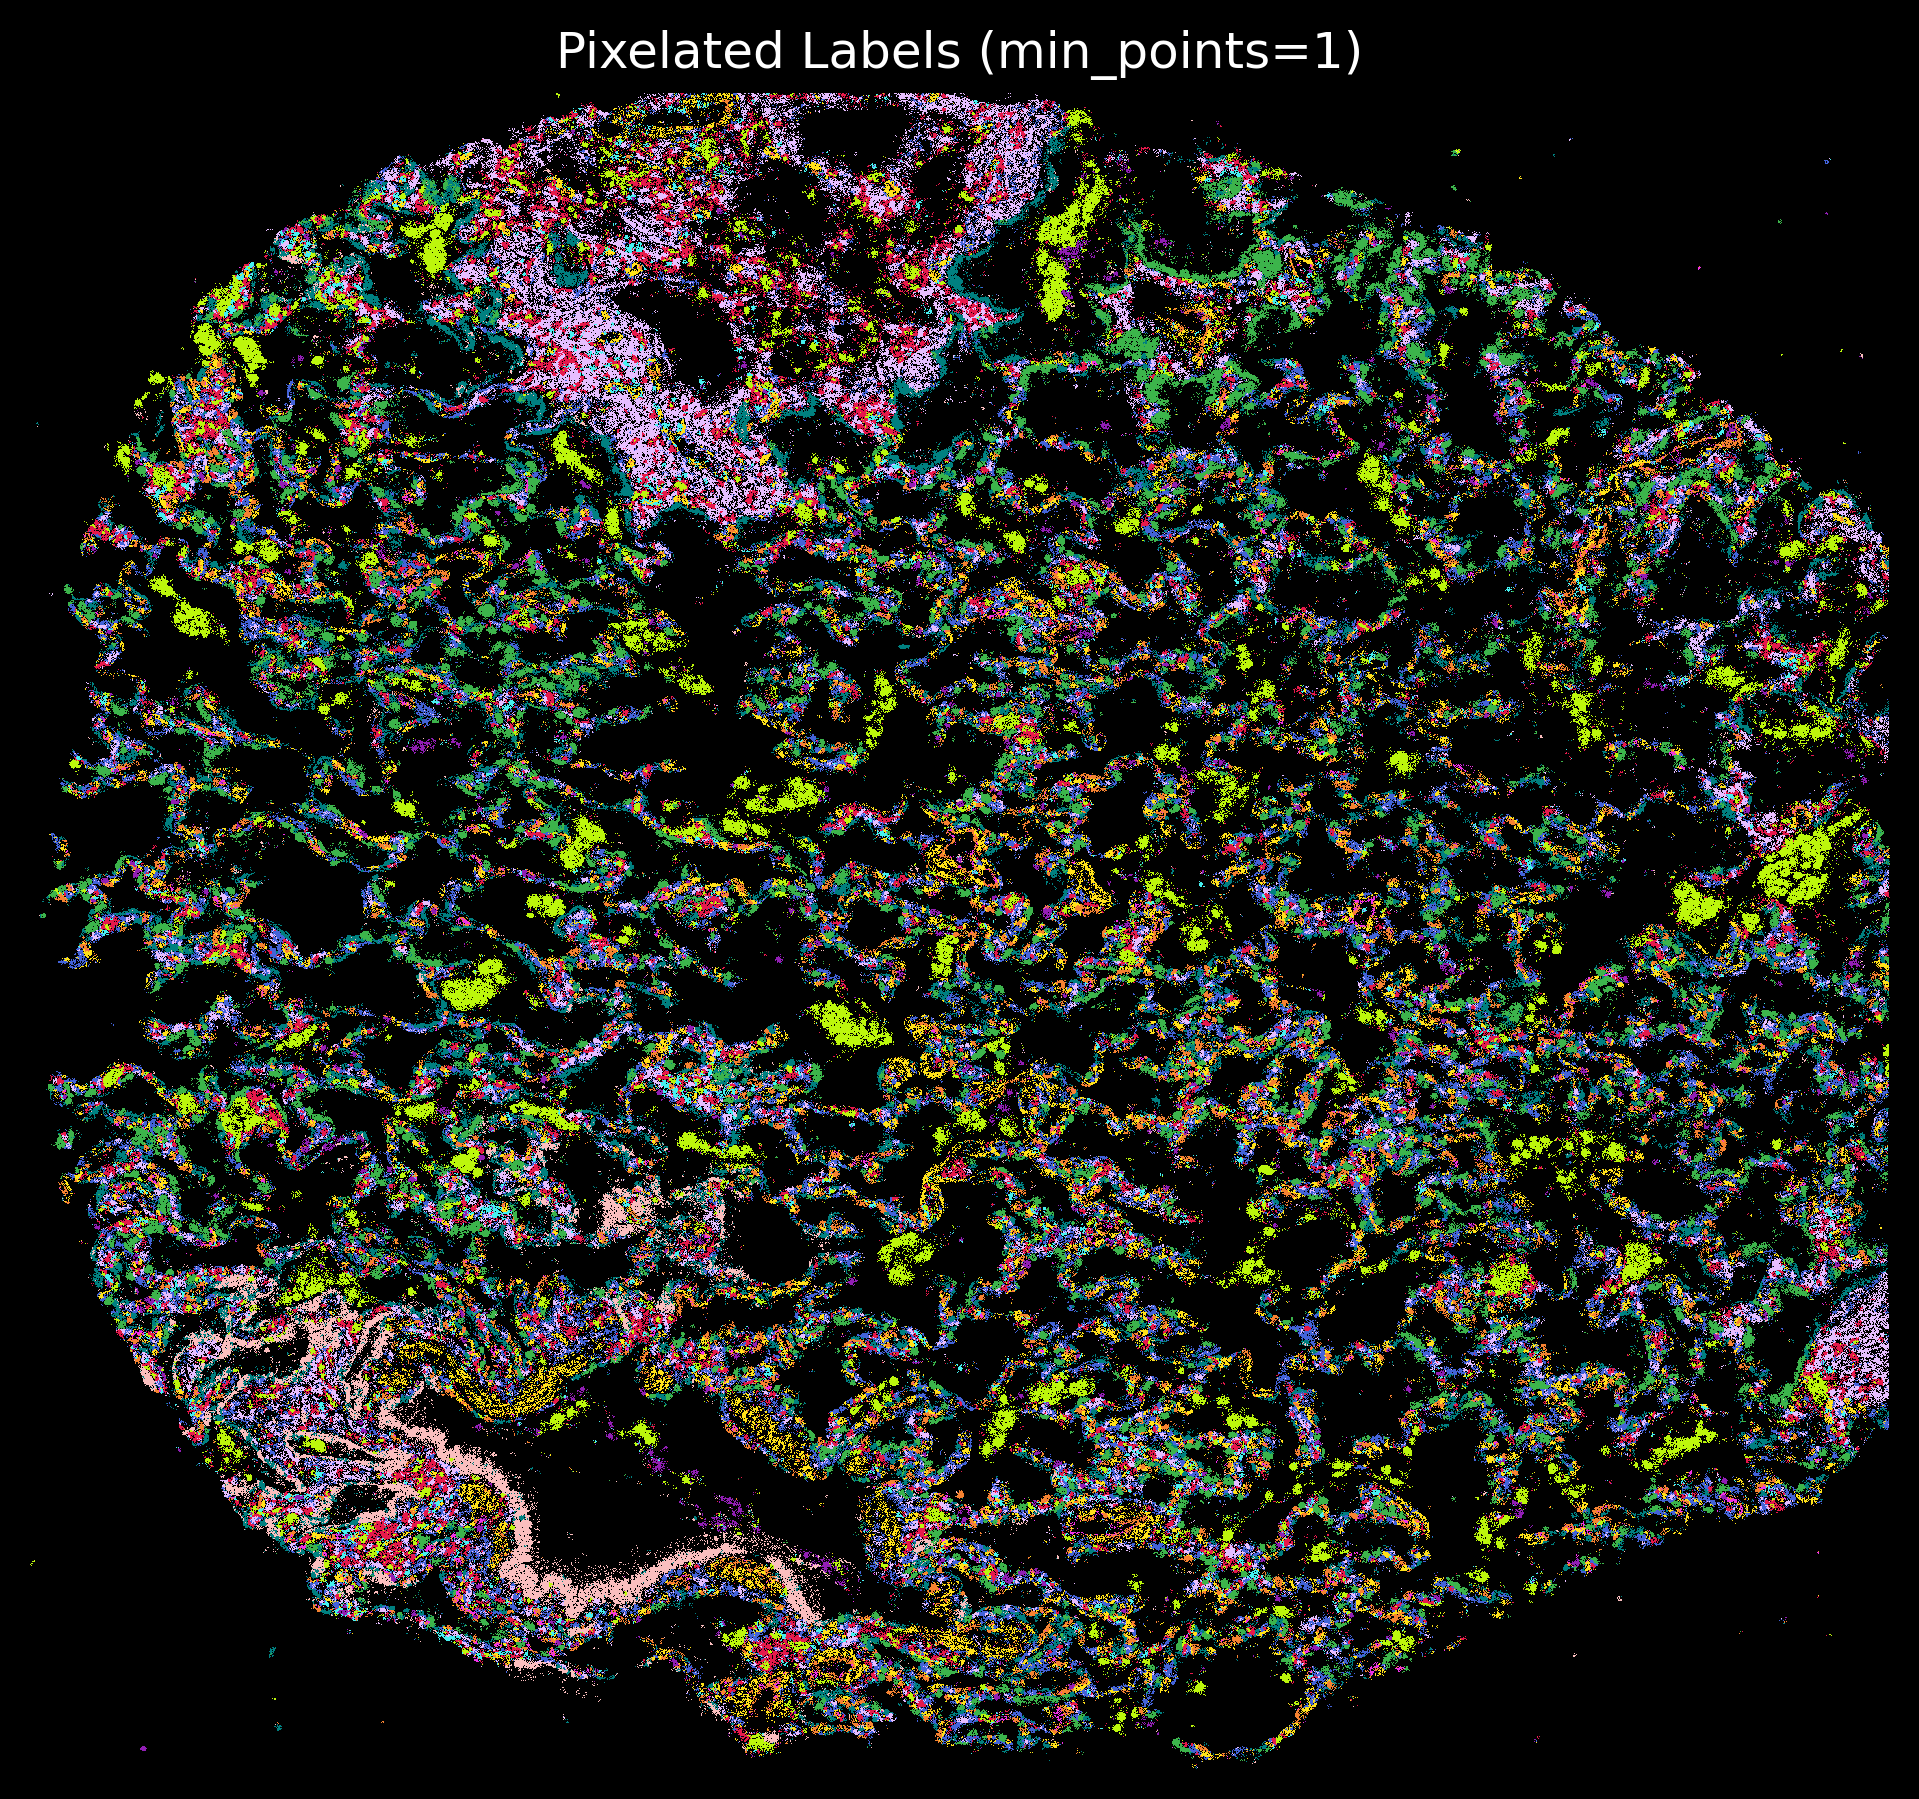

In [93]:
plt.rcParams['figure.facecolor'] = 'black'
plt.style.use('dark_background')
p_fig,ax = viz.plot_pixel(tx_meta = tx_meta_with_clusters_vuild91lf,
                          x="x_location",
                          cmap=customise_cmap,
                          y="y_location",pixel_size=1,min_points=1,
                          background_color="black",dpi=300)
ax.invert_yaxis()